In [991]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_7707/4132600078.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_7707/4132600078.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [992]:
def predict_mean_reversion_label(spread, window, threshold):
    labels = []
    mean = spread.mean()

    for i in range(len(spread)):
        future_spread = spread[i + 1 : i + 1 + window]
        if len(future_spread) < window:
            labels.append(np.nan)
        elif any(abs(j - mean) < threshold for j in future_spread):
            labels.append(1)
        else:
            labels.append(0)

    return pd.Series(labels, index = spread.index)

In [993]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})
    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['rolling_std'] = df['spread'].rolling(window).std()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

optimal_window_threshold = {'IEMG_EEM': {'window': 3, 'threshold': 0.01},
                            'ARKK_ARKW': {'window': 7, 'threshold': 0.03},
                            'TLT_SPTL': {'window': 7, 'threshold': 0.01},
                            'SHY_VGSH': {'window': 7, 'threshold': 0.01},
                            'SOXX_ITA': {'window': 20, 'threshold': 0.1}
}

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = optimal_window_threshold[pair_name]['window']

    threshold = optimal_window_threshold[pair_name]['threshold']

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, window = window, threshold = threshold)
    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, window = window, threshold = threshold)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [994]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [995]:
class ClassificationLSTM(nn.Module):
    def __init__(self, input_size = 7, hidden_size = 50, num_layers = 1):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        # out = self.sigmoid(out)
        return out.squeeze()

In [996]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [997]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    optimal_thresholds = {'IEMG_EEM': 0.5,
                          'ARKK_ARKW': 0.45,
                          'TLT_SPTL': 0.5,
                          'SHY_VGSH': 0.45,
                          'SOXX_ITA': 0.105
                          }
    
    threshold = optimal_thresholds[pair_name]

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [998]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [999]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [1000]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [1001]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, window_size, epochs, device='cpu'):
    
    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)
    
    model = ClassificationLSTM(input_size = 7).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs=epochs, device=device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device=device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)

    return model, y_true, y_pred


Training model for pair: IEMG_EEM
Epoch 1/50 - Loss: 0.7791
Epoch 2/50 - Loss: 0.7648
Epoch 3/50 - Loss: 0.7536
Epoch 4/50 - Loss: 0.7413
Epoch 5/50 - Loss: 0.7269
Epoch 6/50 - Loss: 0.7098
Epoch 7/50 - Loss: 0.6897
Epoch 8/50 - Loss: 0.6675
Epoch 9/50 - Loss: 0.6457
Epoch 10/50 - Loss: 0.6272
Epoch 11/50 - Loss: 0.6122
Epoch 12/50 - Loss: 0.6001
Epoch 13/50 - Loss: 0.5902
Epoch 14/50 - Loss: 0.5822
Epoch 15/50 - Loss: 0.5756
Epoch 16/50 - Loss: 0.5700
Epoch 17/50 - Loss: 0.5653
Epoch 18/50 - Loss: 0.5612
Epoch 19/50 - Loss: 0.5576
Epoch 20/50 - Loss: 0.5543
Epoch 21/50 - Loss: 0.5515
Epoch 22/50 - Loss: 0.5489
Epoch 23/50 - Loss: 0.5466
Epoch 24/50 - Loss: 0.5445
Epoch 25/50 - Loss: 0.5426
Epoch 26/50 - Loss: 0.5407
Epoch 27/50 - Loss: 0.5390
Epoch 28/50 - Loss: 0.5373
Epoch 29/50 - Loss: 0.5358
Epoch 30/50 - Loss: 0.5343
Epoch 31/50 - Loss: 0.5330
Epoch 32/50 - Loss: 0.5318
Epoch 33/50 - Loss: 0.5307
Epoch 34/50 - Loss: 0.5296
Epoch 35/50 - Loss: 0.5286
Epoch 36/50 - Loss: 0.5277
Ep

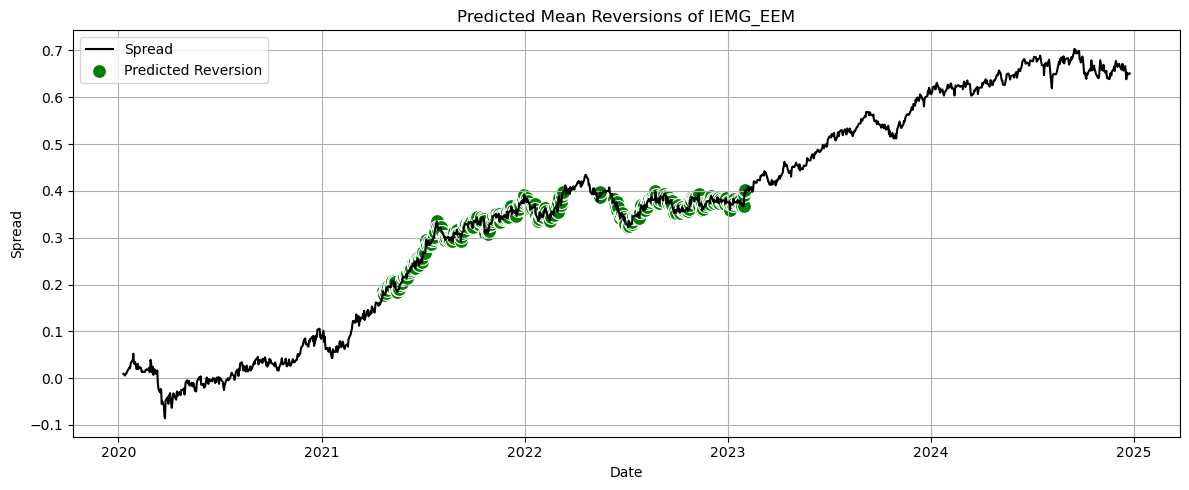

Confusion Matrix:
[[861 253]
 [  0 134]]
F1 Score: 0.5144

Training model for pair: ARKK_ARKW
Epoch 1/50 - Loss: 0.6750
Epoch 2/50 - Loss: 0.6667
Epoch 3/50 - Loss: 0.6613
Epoch 4/50 - Loss: 0.6559
Epoch 5/50 - Loss: 0.6495
Epoch 6/50 - Loss: 0.6418
Epoch 7/50 - Loss: 0.6320
Epoch 8/50 - Loss: 0.6201
Epoch 9/50 - Loss: 0.6067
Epoch 10/50 - Loss: 0.5926
Epoch 11/50 - Loss: 0.5788
Epoch 12/50 - Loss: 0.5657
Epoch 13/50 - Loss: 0.5536
Epoch 14/50 - Loss: 0.5424
Epoch 15/50 - Loss: 0.5320
Epoch 16/50 - Loss: 0.5224
Epoch 17/50 - Loss: 0.5137
Epoch 18/50 - Loss: 0.5060
Epoch 19/50 - Loss: 0.4995
Epoch 20/50 - Loss: 0.4938
Epoch 21/50 - Loss: 0.4888
Epoch 22/50 - Loss: 0.4844
Epoch 23/50 - Loss: 0.4807
Epoch 24/50 - Loss: 0.4774
Epoch 25/50 - Loss: 0.4746
Epoch 26/50 - Loss: 0.4723
Epoch 27/50 - Loss: 0.4702
Epoch 28/50 - Loss: 0.4685
Epoch 29/50 - Loss: 0.4669
Epoch 30/50 - Loss: 0.4656
Epoch 31/50 - Loss: 0.4642
Epoch 32/50 - Loss: 0.4631
Epoch 33/50 - Loss: 0.4621
Epoch 34/50 - Loss: 0.46

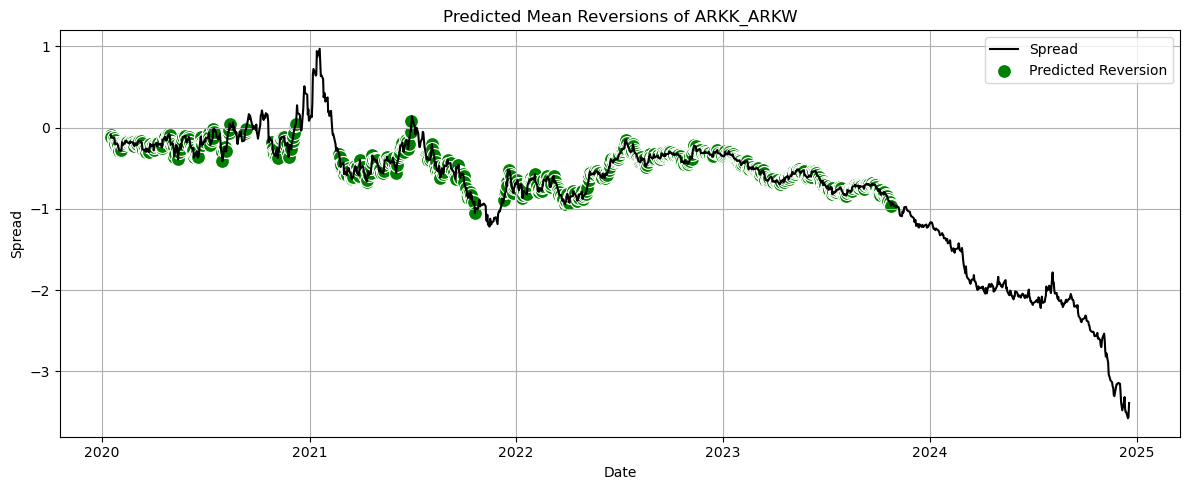

Confusion Matrix:
[[440 657]
 [  6 137]]
F1 Score: 0.2924

Training model for pair: TLT_SPTL
Epoch 1/50 - Loss: 0.4442
Epoch 2/50 - Loss: 0.4365
Epoch 3/50 - Loss: 0.4311
Epoch 4/50 - Loss: 0.4263
Epoch 5/50 - Loss: 0.4217
Epoch 6/50 - Loss: 0.4174
Epoch 7/50 - Loss: 0.4130
Epoch 8/50 - Loss: 0.4085
Epoch 9/50 - Loss: 0.4036
Epoch 10/50 - Loss: 0.3984
Epoch 11/50 - Loss: 0.3929
Epoch 12/50 - Loss: 0.3873
Epoch 13/50 - Loss: 0.3816
Epoch 14/50 - Loss: 0.3761
Epoch 15/50 - Loss: 0.3709
Epoch 16/50 - Loss: 0.3663
Epoch 17/50 - Loss: 0.3622
Epoch 18/50 - Loss: 0.3586
Epoch 19/50 - Loss: 0.3556
Epoch 20/50 - Loss: 0.3530
Epoch 21/50 - Loss: 0.3508
Epoch 22/50 - Loss: 0.3490
Epoch 23/50 - Loss: 0.3474
Epoch 24/50 - Loss: 0.3461
Epoch 25/50 - Loss: 0.3449
Epoch 26/50 - Loss: 0.3439
Epoch 27/50 - Loss: 0.3431
Epoch 28/50 - Loss: 0.3423
Epoch 29/50 - Loss: 0.3416
Epoch 30/50 - Loss: 0.3410
Epoch 31/50 - Loss: 0.3404
Epoch 32/50 - Loss: 0.3399
Epoch 33/50 - Loss: 0.3394
Epoch 34/50 - Loss: 0.338

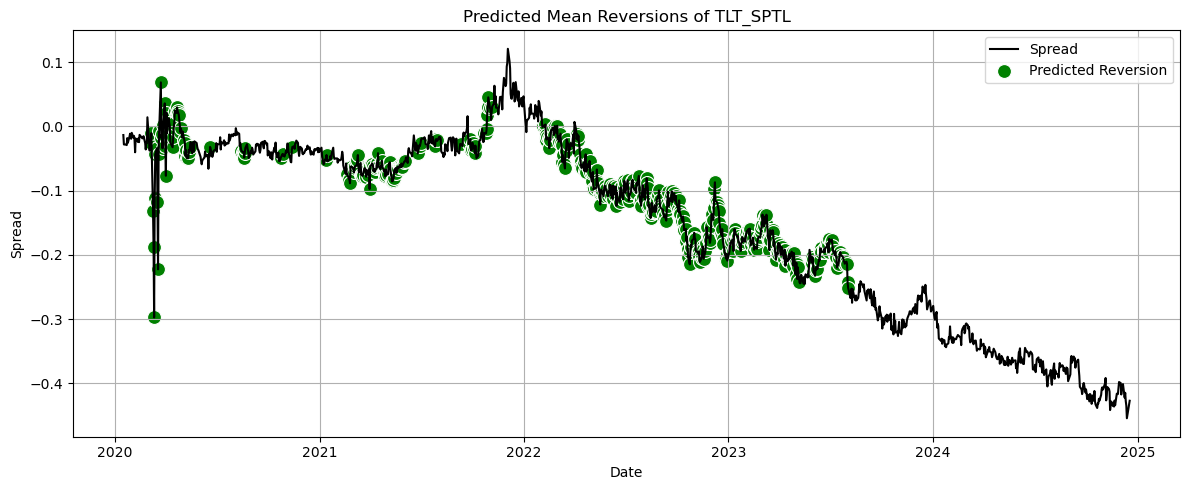

Confusion Matrix:
[[734 425]
 [  0  81]]
F1 Score: 0.2760

Training model for pair: SHY_VGSH
Epoch 1/50 - Loss: 0.3531
Epoch 2/50 - Loss: 0.3423
Epoch 3/50 - Loss: 0.3330
Epoch 4/50 - Loss: 0.3230
Epoch 5/50 - Loss: 0.3118
Epoch 6/50 - Loss: 0.2995
Epoch 7/50 - Loss: 0.2870
Epoch 8/50 - Loss: 0.2762
Epoch 9/50 - Loss: 0.2681
Epoch 10/50 - Loss: 0.2622
Epoch 11/50 - Loss: 0.2578
Epoch 12/50 - Loss: 0.2542
Epoch 13/50 - Loss: 0.2509
Epoch 14/50 - Loss: 0.2477
Epoch 15/50 - Loss: 0.2445
Epoch 16/50 - Loss: 0.2414
Epoch 17/50 - Loss: 0.2384
Epoch 18/50 - Loss: 0.2357
Epoch 19/50 - Loss: 0.2333
Epoch 20/50 - Loss: 0.2312
Epoch 21/50 - Loss: 0.2295
Epoch 22/50 - Loss: 0.2281
Epoch 23/50 - Loss: 0.2269
Epoch 24/50 - Loss: 0.2260
Epoch 25/50 - Loss: 0.2251
Epoch 26/50 - Loss: 0.2244
Epoch 27/50 - Loss: 0.2238
Epoch 28/50 - Loss: 0.2233
Epoch 29/50 - Loss: 0.2228
Epoch 30/50 - Loss: 0.2223
Epoch 31/50 - Loss: 0.2218
Epoch 32/50 - Loss: 0.2214
Epoch 33/50 - Loss: 0.2210
Epoch 34/50 - Loss: 0.220

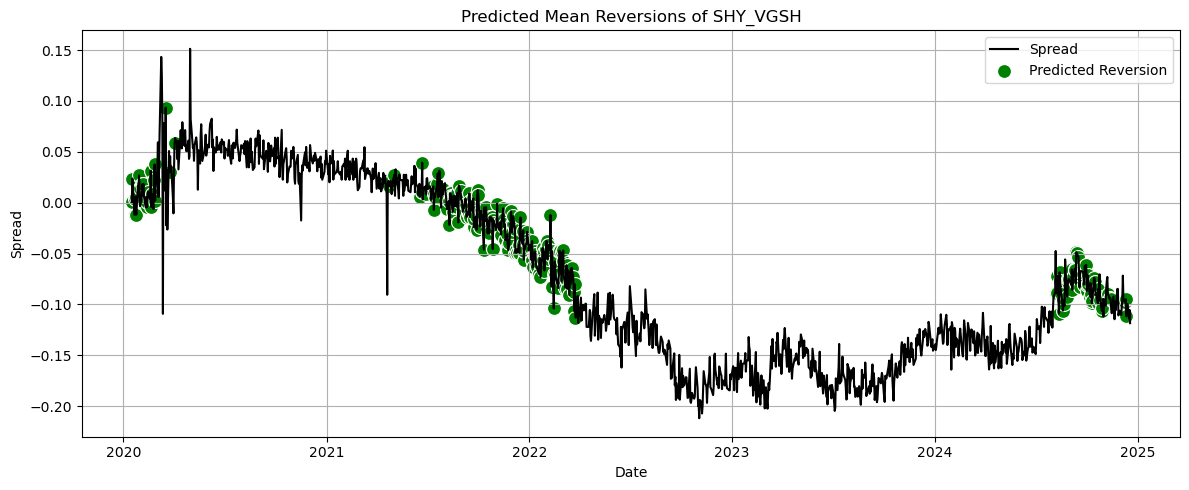

Confusion Matrix:
[[945 162]
 [ 27 106]]
F1 Score: 0.5287

Training model for pair: SOXX_ITA
Epoch 1/50 - Loss: 0.1621
Epoch 2/50 - Loss: 0.1564
Epoch 3/50 - Loss: 0.1545
Epoch 4/50 - Loss: 0.1525
Epoch 5/50 - Loss: 0.1503
Epoch 6/50 - Loss: 0.1477
Epoch 7/50 - Loss: 0.1447
Epoch 8/50 - Loss: 0.1412
Epoch 9/50 - Loss: 0.1371
Epoch 10/50 - Loss: 0.1327
Epoch 11/50 - Loss: 0.1279
Epoch 12/50 - Loss: 0.1229
Epoch 13/50 - Loss: 0.1180
Epoch 14/50 - Loss: 0.1131
Epoch 15/50 - Loss: 0.1087
Epoch 16/50 - Loss: 0.1049
Epoch 17/50 - Loss: 0.1019
Epoch 18/50 - Loss: 0.0995
Epoch 19/50 - Loss: 0.0978
Epoch 20/50 - Loss: 0.0965
Epoch 21/50 - Loss: 0.0955
Epoch 22/50 - Loss: 0.0948
Epoch 23/50 - Loss: 0.0943
Epoch 24/50 - Loss: 0.0939
Epoch 25/50 - Loss: 0.0936
Epoch 26/50 - Loss: 0.0933
Epoch 27/50 - Loss: 0.0931
Epoch 28/50 - Loss: 0.0929
Epoch 29/50 - Loss: 0.0927
Epoch 30/50 - Loss: 0.0925
Epoch 31/50 - Loss: 0.0923
Epoch 32/50 - Loss: 0.0921
Epoch 33/50 - Loss: 0.0920
Epoch 34/50 - Loss: 0.091

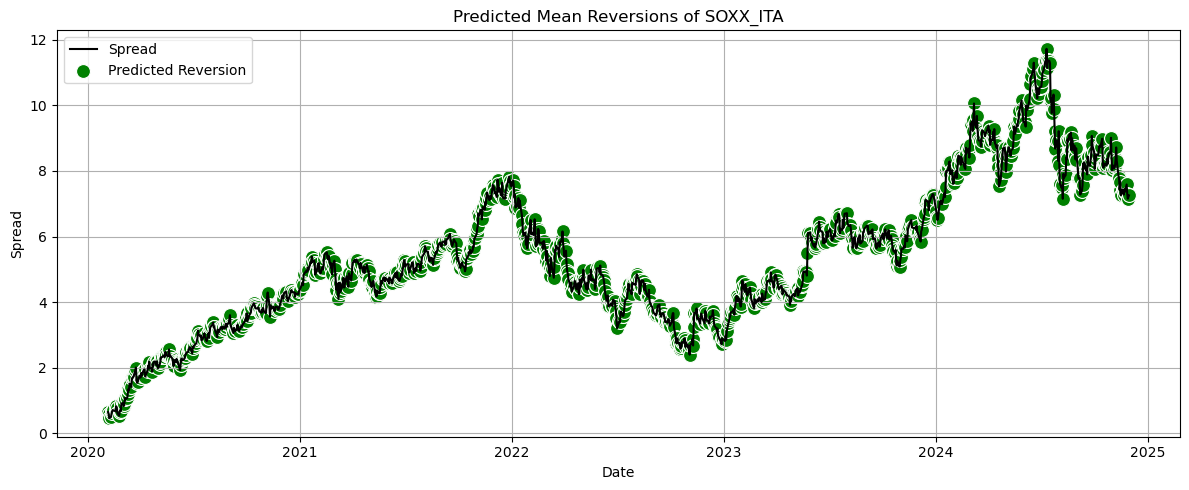

Confusion Matrix:
[[  0 988]
 [  0 226]]
F1 Score: 0.3139
{'IEMG_EEM': {'model': ClassificationLSTM(
  (lstm): LSTM(7, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1248, 1), dtype=float32), 'y_pred': array([0.05523406, 0.07861196, 0.08723129, ..., 0.02002108, 0.02027653,
       0.02001766], shape=(1248,), dtype=float32)}, 'ARKK_ARKW': {'model': ClassificationLSTM(
  (lstm): LSTM(7, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1240, 1), dtype=float32), 'y_pred': array([0.56875986, 0.54798114, 0.52770615, ..., 0.02308246, 0.02306665,
       0.02305798], shape=(1240,), dtype=float32)}, 'TLT_SPTL': {'model': ClassificationLSTM(
  (lstm): LSTM(7, 50, batch_first=True)
  (linear): Linear(in_featur

In [1002]:
results = {}

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        window_size = 3,
        epochs = 50,
        device='cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [1003]:
def simulate_lstm_portfolio(X_df, probs, y_pred_label, initial_cash = 100000, holding_period = 5, entry_threshold = 1, prob_threshold = 0.5):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    # df['prediction'] = y_pred_label

    df['probability'] = probs
    df['position'] = 0
    
    cash = initial_cash
    equity_curve = []
    equity_dates = []

    trade_count = 0
    trade_pnls = []
    trade_dates = []
    notional = 10000

    for i in range(len(df) - holding_period):
        current_row = df.iloc[i]
        date = df.index[i]

        prob = current_row['probability']

        # current_row['prediction'] == 1

        if prob > prob_threshold and abs(current_row['z-score']) > entry_threshold:
            entry_spread = current_row['spread']
            exit_spread = df.iloc[i + holding_period]['spread']
            
            if current_row['z-score'] > 0:
                pnl = (entry_spread - exit_spread) * notional * prob
            else:
                pnl = (exit_spread - entry_spread) * notional * prob

            cash += pnl
            trade_count += 1
            trade_pnls.append(pnl)
            trade_dates.append(date)

        equity_curve.append(cash)
        equity_dates.append(date)

    equity_series = pd.Series(equity_curve, index = equity_dates)
    yearly_values = equity_series.resample('YE').last()

    stats = {
        'final_cash': cash,
        'total_trades': trade_count,
        'trade_pnls': trade_pnls,
        'trade_dates': trade_dates,
        'equity_series': equity_series,
        'yearly_values': yearly_values
    }

    return stats

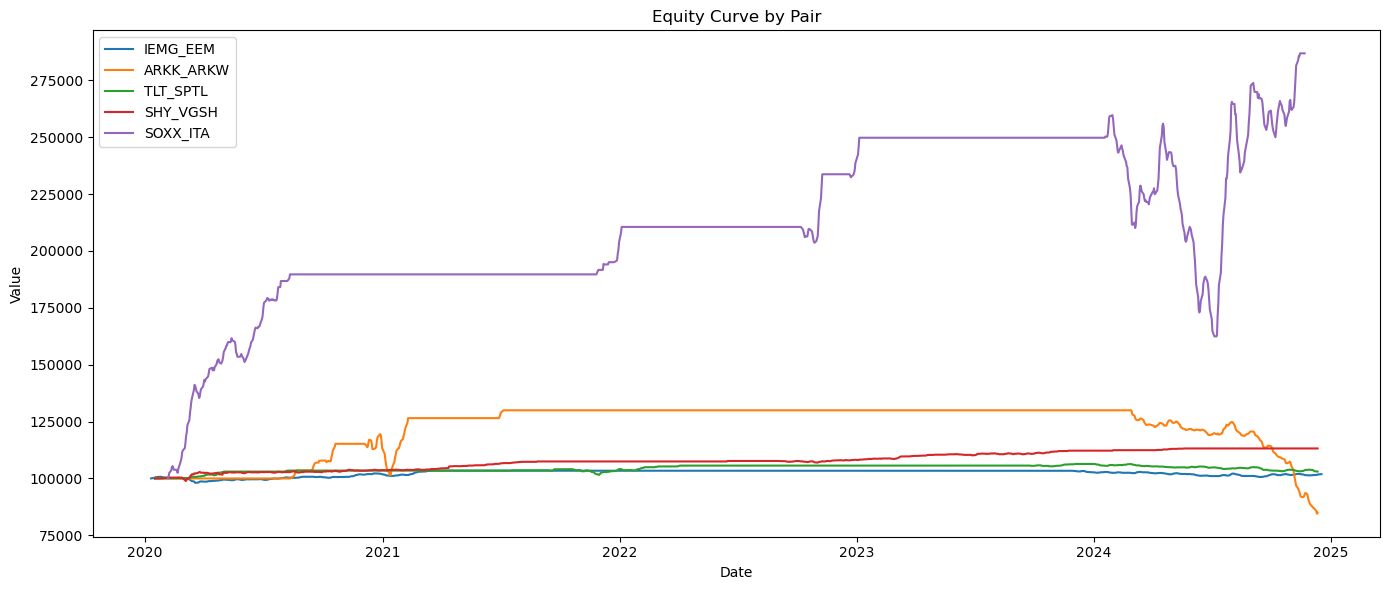


Final Portfolio Value: $689,849.64

Trade Summary: 
  IEMG_EEM: 558 trades | Total PnL: $1883.94 | Avg PnL: $3.38
  ARKK_ARKW: 270 trades | Total PnL: $-15112.88 | Avg PnL: $-55.97
  TLT_SPTL: 387 trades | Total PnL: $3029.30 | Avg PnL: $7.83
  SHY_VGSH: 565 trades | Total PnL: $13183.54 | Avg PnL: $23.33
  SOXX_ITA: 367 trades | Total PnL: $186865.74 | Avg PnL: $509.17

Year-End Portfolio Values:
2020-12-31    612094.821810
2021-12-31    648969.619819
2022-12-31    685884.783470
2023-12-31    701060.237569
2024-12-31    101883.935410
Freq: YE-DEC, dtype: float64


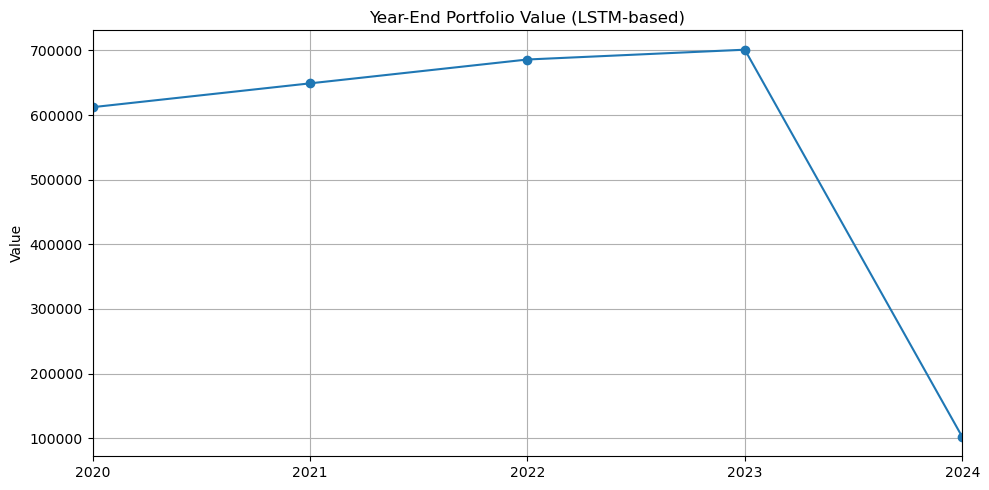

In [1004]:
total_cash = 0
pair_trade_counts = defaultdict(int)
pair_pnls = defaultdict(list)
combined_equity = pd.Series(dtype = float)

plt.figure(figsize = (14, 6))

optimal_thresholds = {'IEMG_EEM': 0.5,
                      'ARKK_ARKW': 0.45,
                      'TLT_SPTL': 0.5,
                      'SHY_VGSH': 0.45,
                      'SOXX_ITA': 0.105
                      }
    
for pair_name in training_spreads_df.columns:
    model_info = results[pair_name]
    model = model_info['model']
    y_true = model_info['y_true']
    y_pred = model_info['y_pred']

    threshold = optimal_thresholds[pair_name]

    y_pred_label = (torch.sigmoid(torch.tensor(y_pred)) > threshold).int().numpy()

    probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().cpu().numpy()

    X_test_df = X_test_dict[pair_name].copy()
    stats = simulate_lstm_portfolio(X_test_df, probs, y_pred_label)

    total_cash += stats['final_cash']
    pair_trade_counts[pair_name] = stats['total_trades']
    pair_pnls[pair_name] = stats['trade_pnls']

    combined_equity = combined_equity.add(stats['equity_series'], fill_value = 0)

    plt.plot(stats['equity_series'], label = pair_name)

plt.title("Equity Curve by Pair")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
print(f"\nTrade Summary: ")
for pair, count in pair_trade_counts.items():
    total_pnl = sum(pair_pnls[pair])
    avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
    print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

yearly = combined_equity.resample('YE').last()
print("\nYear-End Portfolio Values:")
print(yearly)

plt.figure(figsize=(10, 5))
yearly.plot(marker='o')
plt.title("Year-End Portfolio Value (LSTM-based)")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()